In [13]:
import networkx as nx
import pickle
import random
import scipy
from scipy.sparse import tril, find
import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import igraph
from django.core.management import call_command

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.tasks import *

from django.db.models import Count, Sum

qid= 7979
q = Query.objects.get(pk=qid)

sample = 0

# You need to call the management command to generate the network, if this is a new query
regenerate_matrix = False
if regenerate_matrix:
    call_command('citation_matrix', qid)
    call_command('bib_matrix', qid, 0, "/home/galm/projects/anne-adaptation/citation_data")

Cmat = scipy.sparse.load_npz(f'citation_data/bibCouple_q_{qid}_{sample}.npz')

with open(f"citation_data/docnet_dict_q_{qid}_{sample}.pickle", "rb") as f:
    m_dict = pickle.load(f)
with open(f"citation_data/docnet_revdict_q_{qid}_{sample}.pickle", "rb") as f:
    rev_m_dict = pickle.load(f)
    
print(Cmat.shape, Cmat.nnz)
    
# We have a lot of connections! to make this more tractable, I ignore edges with fewer than 3 
# references in common
Cmat.data *= Cmat.data>=3
Cmat.eliminate_zeros()

Cmat



(38541, 38541) 34043191


<38541x38541 sparse matrix of type '<class 'numpy.int64'>'
	with 2092414 stored elements in Compressed Sparse Row format>

In [14]:


def check_cites(bc,rev_m_dict, i=0):
    d1 = Doc.objects.get(pk=rev_m_dict[bc[0][i]])
    d2 = Doc.objects.get(pk=rev_m_dict[bc[1][i]])
    print(bc[2][i])
    return set(d2.wosarticle.cr) & set(d1.wosarticle.cr)

bc = find(tril(Cmat,k=-1))

check_cites(bc, rev_m_dict, 1)



3


{'Baraer M, 2012, J GLACIOL, V58, P134, DOI 10.3189/2012JoG11J186',
 'Bury JT, 2011, CLIMATIC CHANGE, V105, P179, DOI 10.1007/s10584-010-9870-1',
 'Mark BG, 2010, ANN ASSOC AM GEOGR, V100, P794, DOI 10.1080/00045608.2010.497369'}

In [49]:

def read_network(Cmat, rev_m_dict, doc_ids=None):
    g = igraph.Graph()
    g.add_vertices(len(rev_m_dict))
    edges = []
    weights = []
    n1s, n2s, ews = find(tril(Cmat,k=-1))
    for i, n1 in enumerate(n1s):
        if doc_ids:
            if rev_m_dict[n1] not in doc_ids or rev_m_dict[n2s[i]] not in doc_ids:
                continue
        e = (n1,n2s[i])
        edges.append(e)
        weights.append(ews[i])
    g.add_edges(edges)
    g.es["weight"] = weights

    g.vs["doc_id"] = list(rev_m_dict.values())
    return g
    pass



# Set this to the last year we want to include
max_year = 2020
min_year = 2007

# We can filter when we read in the network, if we only want to see an early part of the graph
docs = Doc.objects.filter(pk__in=list(rev_m_dict.values()))#.filter(PY__lte=max_year,PY__gte=min_year)
doc_ids = docs.values_list('pk',flat=True)
print(docs.count())

g = read_network(Cmat, rev_m_dict, doc_ids)

g = g.clusters().giant()
print(g.summary())







38541
IGRAPH U-W- 31058 1026788 -- 
+ attr: doc_id (v), weight (e)


In [50]:
g.vs[1]

igraph.Vertex(<igraph.Graph object at 0x7f6cd16bd7c8>, 1, {'doc_id': 157})

In [51]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=0.6,

    # Log
    verbose=True
)

positions = forceatlas2.forceatlas2_igraph_layout(
    g, pos=None, iterations=1000, weight_attr="weight"
)

100%|██████████| 1000/1000 [27:20<00:00,  1.64s/it]

BarnesHut Approximation  took  443.77  seconds
Repulsion forces  took  1133.63  seconds
Gravitational forces  took  1.56  seconds
Attraction forces  took  39.81  seconds
AdjustSpeedAndApplyForces step  took  8.50  seconds


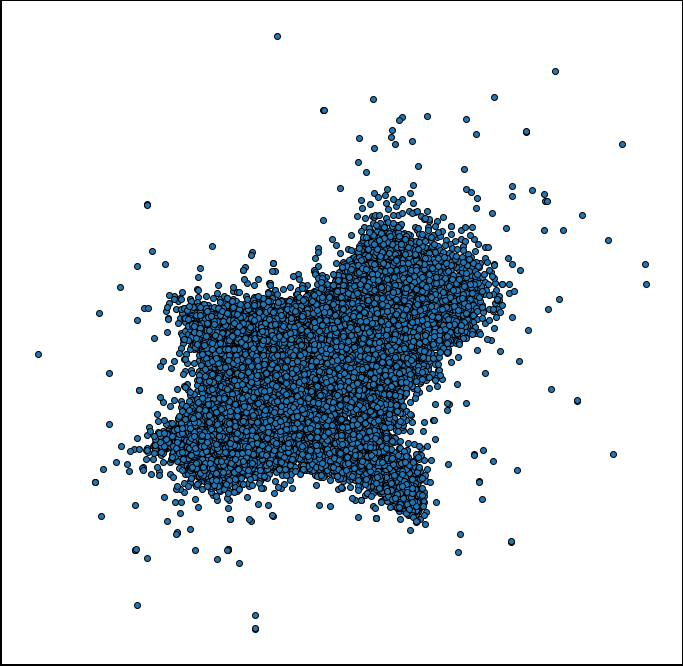

In [52]:
fig, ax = plt.subplots(figsize=(12,12),edgecolor="black",frameon=True,linewidth=4)

x = [x[0] for x in positions]
y = [x[1] for x in positions]
scatter = ax.scatter(x,y,edgecolor="black")

ax.grid(False)
ax.axis("off")

plt.show()

In [53]:
clusters = g.community_fastgreedy(weights="weight")
cl = clusters.as_clustering()

In [54]:
def summarise_cluster(cl, rev_m_dict, qs, c_threshold):
    ids = [g.vs[x]["doc_id"] for x in cl]
    docs = Doc.objects.filter(
        pk__in=ids,
        query__in=qs
    ).values('query__title').annotate(
        n=Count('pk')
    ).order_by('-n')
    df = pd.DataFrame.from_dict(list(docs))
    df['pc'] = round(df['n'] / df['n'].sum(),2)
    t = "\n".join([f"{r['query__title']} - {r['pc']:.0%}" for i,r in df.iterrows() if r['pc']>c_threshold])
    return t
                   
def summarise_category_cluster(cl, project, c_threshold):
    ids = [g.vs[x]["doc_id"] for x in cl]               
    dos = DocOwnership.objects.filter(
        doc__id__in=ids,
        query__project=project,
        relevant=1
    ).values('query__category__name').annotate(
        n = Count('pk')
    ).order_by('-n')
    df = pd.DataFrame.from_dict(list(dos))
    df['pc'] = round(df['n'] / df['n'].sum(),2)
    t = "\n".join([f"{r['query__category__name']} - {r['pc']:.0%}" for i,r in df.iterrows() if r['pc']>c_threshold])
    return t

def summarise_topic_cluster(cl, rev_m_dict, run_id, c_threshold):
    ids = [g.vs[x]["doc_id"] for x in cl]
    docs = Doc.objects.filter(
        pk__in=ids,
        doctopic__run_id=run_id
    ).values('doctopic__topic__title').annotate(
        n=Sum('doctopic__score')
    ).order_by('-n')
    df = pd.DataFrame.from_dict(list(docs))
    df['pc'] = round(df['n'] / df['n'].sum(),2)
    t = "\n".join([f"{r['doctopic__topic__title']} - {r['pc']:.0%}" for i,r in df.iterrows() if r['pc']>c_threshold])
    return t

def draw_network(ax, g, layout, labels, 
                 interactive=False, clusters=None, 
                 qs=None, min_c_size=0,
                 v_padding=50,
                 c_threshold=0.1, run_id=None,
                 rev_m_dict=None, pos="top",
                 category_sum=False,project=None,
                 d_size=5
                ):
    #label_ids = [l['id'] for l in labels]
    ax.grid(False)
    ax.axis('off')
    
    x_offset=0
    if clusters:
        if rev_m_dict:
            pass
            

            
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xrange = xlim[1] - xlim[0]
        yrange = ylim[1] - ylim[0]
        x_step = xrange/3
        if pos=="top":
            ha = "center"
            x_offset = x_step/2
        else:
            ha="left"
            x_offset = xrange
        y_offset = 0
        texts = []
        for i,c in enumerate(clusters):
            x = [x[0] for i,x in enumerate(layout) if i in c]
            y = [x[1] for i,x in enumerate(layout) if i in c] 
            scatter = ax.scatter(x,y, s = d_size, edgecolor="black")
            if len(c) < min_c_size:
                continue
            col = scatter.get_facecolors()[0]
            if qs:
                t = summarise_cluster(c,rev_m_dict,qs,c_threshold)
            elif run_id:
                t = summarise_topic_cluster(c,rev_m_dict,run_id,c_threshold)
            elif category_sum:
                t = summarise_category_cluster(c, project, c_threshold)
            else:
                t = ""
            t = f"Cluster {i} - {len(c)} docs\n\n{t}"
            text = ax.text(
                    xlim[0]+x_offset,
                    ylim[1]+y_offset,
                    t,
                    bbox={'facecolor':col, 'alpha':0.5, 'pad':0.4, 'boxstyle': 'round'},
                    va="top",
                    ha=ha
                )
            texts.append(text)
            if pos=="top":
                x_offset+=x_step
                if xlim[0]+x_offset > xlim[1]:
                    fig.canvas.draw()
                    bs = []
                    for t in texts:
                        box = t.get_bbox_patch().get_window_extent()
                        tcbox = ax.transData.inverted().transform(box)
                        bs.append(tcbox[0][1])

                    y_offset+=min(bs)-ylim[1]
                    x_offset = x_step/2
            else:
                fig.canvas.draw()
                box = text.get_bbox_patch().get_window_extent()
                tcbox = ax.transData.inverted().transform(box)
                b = tcbox[0][1]

                y_offset=b-ylim[1] - v_padding           
            
            
            #ax.text(cx, cy, "ASDFASDFASFD")
    else:
        x = [x[0] for x in layout]
        y = [x[1] for x in layout]
        scatter = ax.scatter(x,y,edgecolor="black")


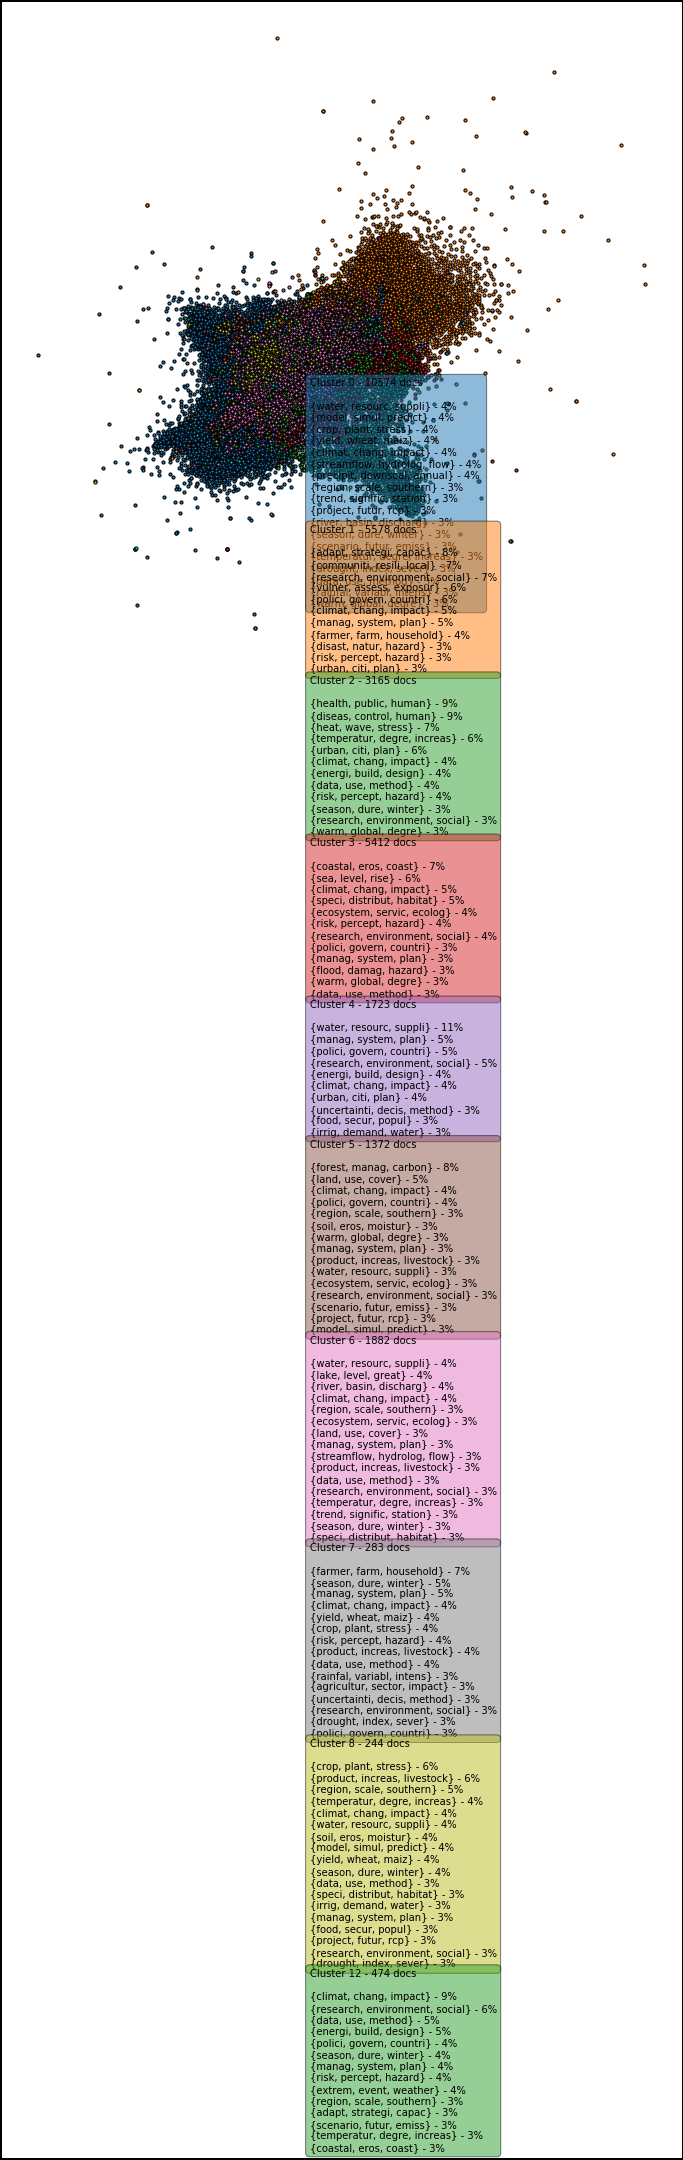

In [55]:
# Label the clusters by topic

fig, ax = plt.subplots(figsize=(12,12),edgecolor="black",frameon=True,linewidth=4)

draw_network(
    ax, g, positions, [], clusters=cl, 
    rev_m_dict=rev_m_dict, run_id=2674,
    min_c_size=100, # Only label clusters with more than this number of documents
    pos="right",
    c_threshold=0.02,
    v_padding=50,
    d_size=10
)


plt.show()